In [159]:
# # for colab compatibility
# !pip install shap
# !pip install ppscore
# !pip install xgboost
# !pip install lightgbm

In [160]:
%run data_load_wrapper.ipynb

In [171]:
from tqdm.notebook import trange
import sklearn.datasets as data
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn import *
from sklearn.feature_selection import *
from sklearn.datasets import make_classification
from sklearn.utils import Bunch
import matplotlib as plt
import seaborn as sns
from boruta import BorutaPy
import shap
import numpy as np
import ppscore as pps
from datetime import datetime
import lightgbm as lgbm
import xgboost

In [172]:
# mse_test = metrics.matthews_corrcoef(y_test, res_test)
# mse_train = metrics.matthews_corrcoef(y_train, res_train)     

In [173]:
def sklearn_to_df(dataset, with_target=False):
    if with_target==False:
        df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
        y = dataset.target
        return df, y
    if with_target==True:
        df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
        y = dataset.target
        df = df.join(pd.Series(y, name='target'))
        return df

def get_feat_imp(imp_type, m, x_train, y_train, random_state):
    imp_type_dict = {
        'mutual_info' : 'mutual_info_classif(x_train, y_train)',
        'f_test' : 'f_classif(x_train, y_train)[0]',       
        'gini' : "m.feature_importances_",
        'pimp' : f"""permutation_importance(m, x_train, y_train, n_repeats=5, 
        random_state={random_state}).importances_mean""",
        'shap' : "abs(np.array(shap.TreeExplainer(m).shap_values(x_train))).sum(axis=0)",
        'pps' : "pps.predictors(x_train.join(y_train), 'target', sorted=False, output='df').model_score",
        'pearson' : "abs(x_train.join(y_train).corr(method='pearson').target).drop('target', axis=0)",
        'spearman': "abs(x_train.join(y_train).corr(method='spearman').target).drop('target', axis=0)",
        'kendall' : "abs(x_train.join(y_train).corr(method='kendall').target).drop('target', axis=0)"
    }
#     print(eval(imp_type_dict.get(imp_type)))
    return eval(imp_type_dict.get(imp_type))

def reduce_dataset(x_train, x_test, drop_index):
    x_train = x_train.drop(x_train.columns[drop_index], axis=1)
    x_test = x_test.drop(x_test.columns[drop_index], axis=1)
    return x_train, x_test

def eval_reduced(x_train, y_train, x_test, y_test, m, imp_type, 
                 dataset, dataset_str, random_state, dataset_state):
    reduce_stats = []
    columns_init = np.array(dataset.feature_names)
#     dataset_name = dataset.filename.split('/')[-1]
    for i in range(len(x_train.columns)):
        mse_train, mse_test, drop_index, feat = model_fit(x_train, y_train, 
                                                     x_test, y_test, m, imp_type,
                                                          random_state)
        global_index = np.where(columns_init==feat);
        global_index = global_index[0][0]
        reduce_stats.append((i, global_index, feat, 
                             mse_train, mse_test, 
                             # get class name, remove trash
                             str(m.__class__).split('.')[-1].replace("\'", '').strip('>'), 
                             imp_type, dataset_str, x_train.columns, 
                             random_state, dataset_state))
        x_train, x_test = reduce_dataset(x_train, x_test, drop_index)
    return reduce_stats

def model_fit(x_train, y_train, x_test, y_test, m, imp_type, random_state):
#     print(x_train.shape, y_train.shape)
#     print(x_test.shape, y_test.shape)
#     refactor1 into function get_metric(type={train, test})
    m.fit(x_train, y_train)
    res_train = m.predict(x_train)
    res_test = m.predict(x_test)
    mse_test = metrics.matthews_corrcoef(y_test, res_test)
    mse_train = metrics.matthews_corrcoef(y_train, res_train)     
    # get the index for feature with lowest global feature importance
    imp = get_feat_imp(imp_type, m, x_train, y_train, random_state)
    argmin_fi_index = imp.argmin()
    feat = x_train.columns[argmin_fi_index]
    return mse_train, mse_test, argmin_fi_index, feat

# def eval_reduced_one_shot(x_train, y_train, x_test, y_test, m, imp_type, 
#                  dataset, dataset_str, random_state, dataset_state):
    
#     reduce_stats = []
#     columns_init = np.array(x_train.columns)
#     m.set_params(random_state = random_state)
#     m.fit(x_train, y_train)
# #     print(x_train.shape)
# #     print(get_feat_imp(imp_type, m, x_train, y_train, random_state).shape)
#     model_str = str(m.__class__).split('.')[-1].replace("\'", '').strip('>')
# #     print(str(m.__class__).split('.')[-1].replace("\'", '').strip('>') == 'XGBClassifier')
#     if model_str != 'XGBClassifier':
#         fi_scores = get_feat_imp(imp_type, m, x_train, y_train, random_state)
#         print(f'not xgbclas {fi_scores.shape}')
# #         fi_scores = fi_scores.sum(axis=0)
#     elif model_str == 'XGBClassifier' and dataset_str == 'wine':      
#         fi_scores = get_feat_imp(imp_type, m, x_train, y_train, random_state)
#         fi_scores = fi_scores.sum(axis=0)
#     else:
#         fi_scores = get_feat_imp(imp_type, m, x_train, y_train, random_state)
#         fi_scores = fi_scores.sum(axis=0)
#         print(fi_scores.shape)
        
# #         print(f'imp: {imp_type} \n model: {m} \n x_shape: {x_train.shape} \n y_shape: {y_train.shape}')
# #         print(f'arr_scores: {fi_scores} \n shape: {fi_scores.shape}')
# #     print(fi_scores)
# #     print(fi_scores.shape)
# #     print(x_train.shape, y_train.shape)
#     for i in range(len(x_train.columns)):
#         mse_train, mse_test, drop_index, feat = model_fit_one_shot(x_train, y_train, 
#                                                      x_test, y_test, m, fi_scores, 
#                                                         random_state)
#         global_index = np.where(columns_init==feat);
#         global_index = global_index[0][0]
# #         print(global_index) 
# #         print(fi_scores)
#         reduce_stats.append((i, global_index, feat, 
#                              mse_train, mse_test, 
#                              # get class name, remove trash
#                              str(m.__class__).split('.')[-1].replace("\'", '').strip('>'), 
#                              imp_type, dataset_str, x_train.columns, 
#                              random_state, dataset_state))
#         x_train, x_test = reduce_dataset(x_train, x_test, drop_index)
# #         print(f'iter {i}')
# #         print(f'local_index: {drop_index}')
# #         print(f'global_index: {global_index}, \n fi before: \n {fi_scores}')
# #         print(fi_scores.shape)
#         fi_scores = np.array(fi_scores)
#         fi_scores = np.delete(fi_scores, drop_index)
# #         print(f'global_index: {global_index}, \n fi after: \n {fi_scores}')              
#     return reduce_stats

def model_fit_one_shot(x_train, y_train, x_test, y_test, m, fi_scores, 
                       random_state):
#     print(x_train.shape, y_train.shape)
#     print(fi_scores.shape)
#     refactor1 into function get_metric(type={train, test})
    m.set_params(random_state=random_state)
    m.fit(x_train, y_train)
    res_train = m.predict(x_train)
    res_test = m.predict(x_test)
    mse_test = metrics.matthews_corrcoef(y_test, res_test)
    mse_train = metrics.matthews_corrcoef(y_train, res_train)     
    # get the index for feature with lowest global feature importance
    imp = fi_scores
    argmin_fi_index = imp.argmin()
    
    feat = x_train.columns[argmin_fi_index]
    return mse_train, mse_test, argmin_fi_index, feat

In [174]:
def get_stats(imp_types, models, datasets, debug=False, random_states=[0], dataset_states=[0]):
    results = []
    datasets_str = list(datasets.keys())
    datasets_data = datasets.items()
    random_state = 0
    
    for ds in trange(len(dataset_states), desc='Data state progress'):
        dataset_state = dataset_states[ds]
        for r in trange(len(random_states), desc='Model random state progress'):
            random_state = random_states[r]

            for j in trange(len(datasets_str), desc=f'Dataset progress'):
                dataset_str = datasets_str[j]
                dataset = datasets.get(datasets_str[j])
                df = sklearn_to_df(dataset, with_target=True)
                x_train, x_test = model_selection.train_test_split(df, 
                                                                   test_size=0.3, 
                                                                   random_state=dataset_state,
                                                                   stratify=df.target
                                                                  )
                columns_init = x_train.columns
                y_train = pd.DataFrame(df.target[x_train.index], 
                                       index=x_train.index)
                y_test = pd.DataFrame(df.target[x_test.index], 
                                      index=x_test.index)
                # remove target column from x_train, x_test
                x_train = x_train.drop('target', axis=1)
                x_test = x_test.drop('target', axis=1)

                for k in trange(len(models), desc=f'Model progress for dataset {j}'):
                    m = models[k]
#                     print(x_train, y_train, x_test, y_test)
                    m.set_params(random_state=random_state)
                    m.fit(x_train, y_train.target)
                    res_test = m.predict(x_test)
                    res_train = m.predict(x_train)
                    mse_test = metrics.matthews_corrcoef(y_test, res_test)
                    mse_train = metrics.matthews_corrcoef(y_train, res_train)    

                    for i in trange(len(imp_types), desc=f'Importance type progress for model {k}'):
                        
                        if imp_types[i] in ['shap', 'pimp', 'pearson', 'spearman', 'kendall',
                                            'pps', 'mutual_info', 'f_test']:   
                            result = eval_reduced_one_shot(x_train, y_train, x_test, y_test, 
                                                           m, imp_types[i], 
                                                           dataset, dataset_str, 
                                                           random_state, dataset_state)
                        else:
                            result = eval_reduced(x_train, y_train.target, x_test, y_test, 
                                                  m, imp_types[i], dataset, dataset_str, 
                                                  random_state, dataset_state)
                        results.extend(result)
                df_res = pd.DataFrame(results, columns=['iteration', 'feat_ind', 'feat_name',
                                                    'mcc_train', 'mcc_test','model', 'imp_type', 
                                                    'dataset', 'features_lst', 
                                                    'random_state', 'data_split'])
        # shift features by 1 row, replace 0th iteration with 'full_set'
        df_res['dropped_feature'] = df_res['feat_name'].shift(1)
        df_res['dropped_feature'] = df_res['dropped_feature'].where(df_res['iteration'] != 0, 'full_set')
        if debug==True:
            repr_lst = ['iteration', 'dropped_feature', 'feat_ind', 'feat_name',
                        'mcc_train', 'mcc_test','model', 'imp_type', 
                        'dataset', 'features_lst','random_state', 'data_split']
        else:
            repr_lst = ['iteration','dropped_feature','mse_train',
         'mse_test','model','imp_type', 'dataset', 'random_state', 'data_split']
        df_res = df_res[repr_lst]
    return df_res

In [175]:
def coerce_synthethic_datasets(samples, features, percent_informative, random_state):
    data, target = make_classification(n_samples=samples, n_features=features, 
                                       n_informative=int(percent_informative*features),
                                       n_redundant=2,
                                       random_state=random_state
                                      )
    feature_names = [f'x_{i}' for i in range(features)]
    # data, target, feature_names
    data_bunch = Bunch(
        data=data,
        target=target,
        feature_names=feature_names,
        informative_features=feature_names[:int(percent_informative*features)]
                        )
    return data_bunch

In [176]:
# for feat, samples in tuples:
#     name = f'classif_features_{feat}_samples_{samples}'
#     # generic method
#     data_bunch = coerce_synthethic_datasets(n_samples=samples, n_features=feat, 
#                     n_informative=int(percent_informative*feat))
    

In [177]:
# dataset = coerce_synthethic_datasets(1000, 10, 0.2, 0)

In [178]:
# for feat, samples in tuples:
#     name = f'classif_features_{feat}_samples_{samples}'
#     # generic method
#     data, target = make_classification(n_samples=samples, n_features=feat, 
#                     n_informative=int(percent_informative*feat))
    

In [179]:
# {
# f'classif_features_{feat}_samples_{samples}':
#     make_classification(n_samples=samples, n_features=feat, 
#                     n_informative=percent_informative*feat)
# for i, (feat, samples) in enumerate(tuples)
# }

In [245]:
imp_types = [
             'gini',
             'mutual_info',
             'f_test',
             'pimp', 
             'shap', 
             'pearson', 
             'spearman', 
             'kendall', 
             'pps'
            ]
models = [
          tree.DecisionTreeClassifier(random_state=0), 
          ensemble.RandomForestClassifier(random_state=0, n_jobs=3), 
          xgboost.XGBClassifier(random_state=0, n_jobs=3, use_label_encoder=False,
                               verbosity=0),
         ]

random_states = [i for i in range(1)]
# synthethic_states = [i for i in range(1)]
dataset_states = [i for i in range(1)]

features = [10, 100]
samples = [100, 1000]
# features = [100]
# samples = [1000]
synthethic_states = [i for i in range(10)]
percent_informative = 0.2

tuples = []
for i in features:
    for j in samples:
        for k in synthethic_states:            
            tuples.append((i,j,k))
datasets = {}

In [246]:
for feat, samples, random_seed in tuples:
    datasets[f'classif_features_{feat}_samples_{samples}_seed_{random_seed}'] = coerce_synthethic_datasets(samples, feat, 0.2, random_seed)

In [247]:
import warnings
warnings.filterwarnings('ignore')

In [248]:
def eval_reduced_one_shot(x_train, y_train, x_test, y_test, m, imp_type, 
                 dataset, dataset_str, random_state, dataset_state):
    
    model_str = str(m.__class__).split('.')[-1].replace("\'", '').strip('>')
    reduce_stats = []
    columns_init = np.array(x_train.columns)
    m.set_params(random_state = random_state)
    print(m.__class__, x_train.shape, y_train.shape, dataset_str, imp_type)
    if  dataset_str == 'wine' and model_str == 'XGBClassifier':      
        m.set_params(num_class = 3)
    m.fit(x_train, y_train)
#     print(dataset_str, imp_type, m.__class__, x_train.shape, y_train.shape, random_state)
    if imp_type == 'shap' and model_str != 'XGBClassifier':
        fi_scores = get_feat_imp(imp_type, m, x_train, y_train, random_state)
#         print(1)
#         print(fi_scores.shape)
        fi_scores = fi_scores.sum(axis=0)
    elif model_str == 'XGBClassifier' and model_str == 'shap':
        fi_scores = get_feat_imp(imp_type, m, x_train, y_train, random_state)
#         fi_scores = fi_scores.sum(axis=0)
#         print(2)
#         print(fi_scores.shape)
    elif model_str == 'XGBClassifier' and dataset_str == 'wine' and imp_type == 'shap':
#         print(3)
        fi_scores = get_feat_imp(imp_type, m, x_train, y_train, random_state)
        fi_scores = fi_scores.sum(axis=0)
#     elif model_str == 'XGBClassifier' and imp_type == 'shap':
#         print(4)
#         fi_scores = get_feat_imp(imp_type, m, x_train, y_train, random_state)
#         fi_scores = fi_scores.sum(axis=0)
    else:
#         print(5)
        fi_scores = get_feat_imp(imp_type, m, x_train, y_train, random_state)
        
    for i in range(len(x_train.columns)):
        mse_train, mse_test, drop_index, feat = model_fit_one_shot(x_train, y_train, 
                                                     x_test, y_test, m, fi_scores, 
                                                        random_state)
        global_index = np.where(columns_init==feat);
        global_index = global_index[0][0]
        reduce_stats.append((i, global_index, feat, 
                             mse_train, mse_test, 
                             # get class name, remove trash
                             str(m.__class__).split('.')[-1].replace("\'", '').strip('>'), 
                             imp_type, dataset_str, x_train.columns, 
                             random_state, dataset_state))
        x_train, x_test = reduce_dataset(x_train, x_test, drop_index)
#         print(f'iter {i}')
#         print(f'local_index: {drop_index}')
#         print(f'global_index: {global_index}, \n fi before: \n {fi_scores}')
#         print(fi_scores.shape)
        fi_scores = np.array(fi_scores)
        fi_scores = np.delete(fi_scores, drop_index)
#         print(f'global_index: {global_index}, \n fi after: \n {fi_scores}')              
    return reduce_stats

In [249]:
df_res = get_stats(imp_types, models, datasets, debug=True, 
                   random_states = random_states, dataset_states = dataset_states
                  )

Data state progress:   0%|          | 0/1 [00:00<?, ?it/s]

Model random state progress:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset progress:   0%|          | 0/40 [00:00<?, ?it/s]

Model progress for dataset 0:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 f_test
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 pimp
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 shap
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 pearson
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 spearman
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 kendall
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_0 pps


Model progress for dataset 1:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 f_test
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 pimp
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 shap
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 pearson
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 spearman
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 kendall
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_1 pps


Model progress for dataset 2:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 f_test
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 pimp
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 shap
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 pearson
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 spearman
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 kendall
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_2 pps


Model progress for dataset 3:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 f_test
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 pimp
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 shap
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 pearson
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 spearman
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 kendall
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_3 pps


Model progress for dataset 4:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 f_test
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 pimp
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 shap
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 pearson
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 spearman
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 kendall
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_4 pps


Model progress for dataset 5:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 f_test
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 pimp
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 shap
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 pearson
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 spearman
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 kendall
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_5 pps


Model progress for dataset 6:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 f_test
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 pimp
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 shap
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 pearson
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 spearman
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 kendall
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_6 pps


Model progress for dataset 7:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 f_test
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 pimp
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 shap
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 pearson
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 spearman
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 kendall
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_7 pps


Model progress for dataset 8:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 f_test
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 pimp
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 shap
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 pearson
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 spearman
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 kendall
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_8 pps


Model progress for dataset 9:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 f_test
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 pimp
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 shap
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 pearson
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 spearman
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 kendall
<class 'xgboost.sklearn.XGBClassifier'> (70, 10) (70, 1) classif_features_10_samples_100_seed_9 pps


Model progress for dataset 10:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 f_test
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 pimp
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 shap
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 pearson
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 spearman
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 kendall
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_0 pps


Model progress for dataset 11:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 f_test
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 pimp
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 shap
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 pearson
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 spearman
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 kendall
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_1 pps


Model progress for dataset 12:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 f_test
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 pimp
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 shap
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 pearson
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 spearman
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 kendall
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_2 pps


Model progress for dataset 13:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 f_test
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 pimp
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 shap
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 pearson
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 spearman
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 kendall
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_3 pps


Model progress for dataset 14:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 f_test
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 pimp
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 shap
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 pearson
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 spearman
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 kendall
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_4 pps


Model progress for dataset 15:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 f_test
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 pimp
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 shap
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 pearson
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 spearman
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 kendall
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_5 pps


Model progress for dataset 16:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 f_test
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 pimp
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 shap
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 pearson
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 spearman
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 kendall
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_6 pps


Model progress for dataset 17:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 f_test
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 pimp
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 shap
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 pearson
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 spearman
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 kendall
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_7 pps


Model progress for dataset 18:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 f_test
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 pimp
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 shap
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 pearson
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 spearman
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 kendall
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_8 pps


Model progress for dataset 19:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 f_test
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 pimp
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 shap
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 pearson
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 spearman
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 kendall
<class 'xgboost.sklearn.XGBClassifier'> (700, 10) (700, 1) classif_features_10_samples_1000_seed_9 pps


Model progress for dataset 20:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 f_test
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 pimp
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 shap
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 pearson
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 spearman
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 kendall
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_0 pps


Model progress for dataset 21:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 f_test
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 pimp
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 shap
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 pearson
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 spearman
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 kendall
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_1 pps


Model progress for dataset 22:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 f_test
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 pimp
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 shap
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 pearson
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 spearman
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 kendall
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_2 pps


Model progress for dataset 23:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 f_test
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 pimp
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 shap
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 pearson
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 spearman
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 kendall
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_3 pps


Model progress for dataset 24:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 f_test
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 pimp
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 shap
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 pearson
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 spearman
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 kendall
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_4 pps


Model progress for dataset 25:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 f_test
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 pimp
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 shap
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 pearson
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 spearman
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 kendall
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_5 pps


Model progress for dataset 26:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 f_test
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 pimp
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 shap
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 pearson
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 spearman
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 kendall
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_6 pps


Model progress for dataset 27:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 f_test
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 pimp
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 shap
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 pearson
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 spearman
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 kendall
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_7 pps


Model progress for dataset 28:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 f_test
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 pimp
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 shap
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 pearson
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 spearman
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 kendall
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_8 pps


Model progress for dataset 29:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 pps


Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 f_test
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 pimp
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 shap
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 pearson
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 spearman
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 kendall
<class 'xgboost.sklearn.XGBClassifier'> (70, 100) (70, 1) classif_features_100_samples_100_seed_9 pps


Model progress for dataset 30:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_s

Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 f_test
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 pimp
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 shap
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 pearson
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 spearman
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 kendall
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_0 pps


Model progress for dataset 31:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_s

Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 f_test
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 pimp
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 shap
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 pearson
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 spearman
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 kendall
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_1 pps


Model progress for dataset 32:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_s

Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 f_test
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 pimp
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 shap
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 pearson
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 spearman
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 kendall
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_2 pps


Model progress for dataset 33:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_s

Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 f_test
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 pimp
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 shap
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 pearson
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 spearman
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 kendall
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_3 pps


Model progress for dataset 34:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_s

Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 f_test
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 pimp
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 shap
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 pearson
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 spearman
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 kendall
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_4 pps


Model progress for dataset 35:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_s

Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 f_test
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 pimp
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 shap
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 pearson
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 spearman
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 kendall
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_5 pps


Model progress for dataset 36:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_s

Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 f_test
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 pimp
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 shap
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 pearson
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 spearman
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 kendall
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_6 pps


Model progress for dataset 37:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_s

Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 f_test
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 pimp
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 shap
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 pearson
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 spearman
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 kendall
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_7 pps


Model progress for dataset 38:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_s

Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 f_test
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 pimp
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 shap
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 pearson
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 spearman
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 kendall
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_8 pps


Model progress for dataset 39:   0%|          | 0/3 [00:00<?, ?it/s]

Importance type progress for model 0:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 mutual_info
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 f_test
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 pimp
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 shap
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 pearson
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 spearman
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 kendall
<class 'sklearn.tree._classes.DecisionTreeClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 pps


Importance type progress for model 1:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 mutual_info
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 f_test
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 pimp
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 shap
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 pearson
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 spearman
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 kendall
<class 'sklearn.ensemble._forest.RandomForestClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_s

Importance type progress for model 2:   0%|          | 0/9 [00:00<?, ?it/s]

<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 mutual_info
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 f_test
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 pimp
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 shap
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 pearson
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 spearman
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 kendall
<class 'xgboost.sklearn.XGBClassifier'> (700, 100) (700, 1) classif_features_100_samples_1000_seed_9 pps


In [239]:
df_res

,iteration,dropped_feature,feat_ind,feat_name,mcc_train,mcc_test,model,imp_type,dataset,features_lst,random_state,data_split
0,0,full_set,0,x_0,1.000000,0.935414,DecisionTreeClassifier,gini,classif_features_10_samples_100_seed_0,"Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5...",0,0
1,1,x_0,3,x_3,1.000000,0.866071,DecisionTreeClassifier,gini,classif_features_10_samples_100_seed_0,"Index(['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6...",0,0
2,2,x_3,4,x_4,1.000000,0.866071,DecisionTreeClassifier,gini,classif_features_10_samples_100_seed_0,"Index(['x_1', 'x_2', 'x_4', 'x_5', 'x_6', 'x_7...",0,0
3,3,x_4,5,x_5,1.000000,0.866071,DecisionTreeClassifier,gini,classif_features_10_samples_100_seed_0,"Index(['x_1', 'x_2', 'x_5', 'x_6', 'x_7', 'x_8...",0,0
4,4,x_5,6,x_6,1.000000,0.866071,DecisionTreeClassifier,gini,classif_features_10_samples_100_seed_0,"Index(['x_1', 'x_2', 'x_6', 'x_7', 'x_8', 'x_9...",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5935,95,x_32,95,x_95,1.000000,0.053333,XGBClassifier,pps,classif_features_100_samples_1000_seed_0,"Index(['x_27', 'x_38', 'x_73', 'x_86', 'x_95']...",0,0
5936,96,x_95,27,x_27,1.000000,0.066667,XGBClassifier,pps,classif_features_100_samples_1000_seed_0,"Index(['x_27', 'x_38', 'x_73', 'x_86'], dtype=...",0,0
5937,97,x_27,86,x_86,1.000000,-0.067049,XGBClassifier,pps,classif_features_100_samples_1000_seed_0,"Index(['x_38', 'x_73', 'x_86'], dtype='object')",0,0
5938,98,x_86,38,x_38,0.954302,0.020004,XGBClassifier,pps,classif_features_100_samples_1000_seed_0,"Index(['x_38', 'x_73'], dtype='object')",0,0


In [252]:
df_res

,iteration,dropped_feature,feat_ind,feat_name,mcc_train,mcc_test,model,imp_type,dataset,features_lst,random_state,data_split
0,0,full_set,0,x_0,1.000000,0.935414,DecisionTreeClassifier,gini,classif_features_10_samples_100_seed_0,"Index(['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5...",0,0
1,1,x_0,3,x_3,1.000000,0.866071,DecisionTreeClassifier,gini,classif_features_10_samples_100_seed_0,"Index(['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6...",0,0
2,2,x_3,4,x_4,1.000000,0.866071,DecisionTreeClassifier,gini,classif_features_10_samples_100_seed_0,"Index(['x_1', 'x_2', 'x_4', 'x_5', 'x_6', 'x_7...",0,0
3,3,x_4,5,x_5,1.000000,0.866071,DecisionTreeClassifier,gini,classif_features_10_samples_100_seed_0,"Index(['x_1', 'x_2', 'x_5', 'x_6', 'x_7', 'x_8...",0,0
4,4,x_5,6,x_6,1.000000,0.866071,DecisionTreeClassifier,gini,classif_features_10_samples_100_seed_0,"Index(['x_1', 'x_2', 'x_6', 'x_7', 'x_8', 'x_9...",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
59395,95,x_7,9,x_9,1.000000,-0.006670,XGBClassifier,pps,classif_features_100_samples_1000_seed_9,"Index(['x_9', 'x_30', 'x_50', 'x_65', 'x_79'],...",0,0
59396,96,x_9,79,x_79,1.000000,0.000000,XGBClassifier,pps,classif_features_100_samples_1000_seed_9,"Index(['x_30', 'x_50', 'x_65', 'x_79'], dtype=...",0,0
59397,97,x_79,65,x_65,0.991432,-0.060012,XGBClassifier,pps,classif_features_100_samples_1000_seed_9,"Index(['x_30', 'x_50', 'x_65'], dtype='object')",0,0
59398,98,x_65,30,x_30,0.965776,-0.113457,XGBClassifier,pps,classif_features_100_samples_1000_seed_9,"Index(['x_30', 'x_50'], dtype='object')",0,0


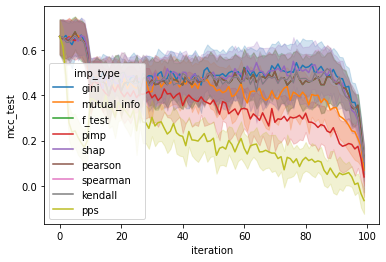

In [255]:
import seaborn as sns

plot = sns.lineplot(x='iteration', y='mcc_test', hue='imp_type',
            data=df_res.query('''model == "RandomForestClassifier"''')
            )

In [14]:
# import seaborn as sns

# plot = sns.lineplot(x='iteration', y='mse_test', hue='imp_type',
#             data=df_res.query('dataset == "wine" and model == "RandomForestClassifier"')
#             )

In [250]:
# export results to local dir as csv file
df_res.to_csv(f'classification_synthethic_data_{datetime.today().strftime("%Y-%b-%d-%H:%M:%S")}.csv',
             index=False)